<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/U_Net_Klein_beta_LinAdj_Bump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repeated tests with U-Net and Klein-beta plane using liear adjoint mapping from obs to grid.

# **1. Imports and device**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

np.random.seed(123)
torch.manual_seed(123)
if device.type == "cuda":
    torch.cuda.manual_seed_all(123)


Using device: cpu


# **1. Klein-$\beta$ ICs (2-layer SW, A-grid)**

In [ ]:
def make_ic_sw2l_klein_beta(
    Nx=64,
    Ny=32,
    g=9.81,
    H1=500.0,
    H2=500.0,
    f_p=1.0e-4,       # polar f
    A_bt=10.0,        # barotropic height amplitude
    A_bc=20.0,        # baroclinic height amplitude
    alpha=1.0,        # baroclinic strength
    R_frac=0.3,       # Gaussian radius fraction of π
    vel_noise=0.02,   # small random velocity noise
    f_min_frac=0.2,   # floor for |f| as fraction of |f_p|
    seed=None,
):
    """
    2-layer SW-like IC on Klein-β plane (A-grid):

      x ∈ [-π, π], y ∈ [-π/2, π/2]
      f = f_p * sin(y)
      Klein identifications at y = ±π/2:
        h(x, π/2)  =  h(-x, -π/2)
        u(x, π/2)  = -u(-x, -π/2)
        v(x, π/2)  =  v(-x, -π/2)
    """
    rng = np.random.RandomState(seed)

    # Grid
    dx = 2.0 * np.pi / Nx
    dy = np.pi / Ny
    x = -np.pi + (np.arange(Nx) + 0.5) * dx
    y = -0.5 * np.pi + (np.arange(Ny) + 0.5) * dy
    X, Y = np.meshgrid(x, y)

    # Coriolis and regularized f
    f = f_p * np.sin(Y)
    f_floor = f_min_frac * np.abs(f_p)
    f_eff = np.where(np.abs(f) < f_floor,
                     np.sign(f) * f_floor,
                     f)

    # Barotropic + baroclinic height anomalies
    eta_bt = A_bt * np.cos(X) * np.cos(2.0 * Y)

    x_c = rng.uniform(-0.5 * np.pi, 0.5 * np.pi)
    y_c = rng.uniform(-0.3 * np.pi, 0.3 * np.pi)
    R = R_frac * np.pi
    rr2 = (X - x_c) ** 2 + (Y - y_c) ** 2
    eta_bc = A_bc * np.exp(-rr2 / R**2) * np.cos(2.0 * X)

    eta1 = eta_bt + alpha * eta_bc
    eta2 = eta_bt - alpha * eta_bc

    h1 = np.maximum(H1 + eta1, 1.0)
    h2 = np.maximum(H2 + eta2, 1.0)

    # Derivatives
    def ddx(field):
        return (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2.0 * dx)

    def ddy_rect(field):
        Ny_, Nx_ = field.shape
        d = np.zeros_like(field)
        d[1:-1, :] = (field[2:, :] - field[:-2, :]) / (2.0 * dy)
        d[0, :]    = (field[1, :] - field[0, :]) / dy
        d[-1, :]   = (field[-1, :] - field[-2, :]) / dy
        return d

    d_eta1_dx = ddx(eta1)
    d_eta1_dy = ddy_rect(eta1)
    d_eta2_dx = ddx(eta2)
    d_eta2_dy = ddy_rect(eta2)

    # Geostrophic-like velocities
    u1 = - (g / f_eff) * d_eta1_dy
    v1 =   (g / f_eff) * d_eta1_dx
    u2 = - (g / f_eff) * d_eta2_dy
    v2 =   (g / f_eff) * d_eta2_dx

    # Add small noise
    if vel_noise > 0.0:
        u1 += vel_noise * rng.randn(*u1.shape)
        v1 += vel_noise * rng.randn(*v1.shape)
        u2 += vel_noise * rng.randn(*u2.shape)
        v2 += vel_noise * rng.randn(*v2.shape)

    # Enforce Klein identifications at top/bottom
    Ny_, Nx_ = h1.shape
    j_bot = 0
    j_top = Ny_ - 1
    i_all = np.arange(Nx_)
    i_mirror = Nx_ - 1 - i_all

    # Scalars
    h1[j_top, i_all] = h1[j_bot, i_mirror]
    h2[j_top, i_all] = h2[j_bot, i_mirror]

    # Velocities
    u1[j_top, i_all] = -u1[j_bot, i_mirror]
    u2[j_top, i_all] = -u2[j_bot, i_mirror]
    v1[j_top, i_all] =  v1[j_bot, i_mirror]
    v2[j_top, i_all] =  v2[j_bot, i_mirror]

    return h1, h2, u1, v1, u2, v2


def build_ic_dataset_sw2l_klein_beta(
    N_samples=200,
    Nx=64,
    Ny=32,
    base_seed=123,
):
    """
    Static 2-layer SW ICs on Klein-β plane.
    Returns truth: (N_samples, 6, Ny, Nx)
    """
    C_state = 6
    truth = np.zeros((N_samples, C_state, Ny, Nx), dtype=np.float32)

    for i in range(N_samples):
        seed = base_seed + i
        A_bt = 10.0 * (0.5 + np.random.rand())
        A_bc = 20.0 * (0.5 + np.random.rand())

        h1, h2, u1, v1, u2, v2 = make_ic_sw2l_klein_beta(
            Nx=Nx,
            Ny=Ny,
            A_bt=A_bt,
            A_bc=A_bc,
            seed=seed,
        )

        truth[i, 0] = h1
        truth[i, 1] = h2
        truth[i, 2] = u1
        truth[i, 3] = v1
        truth[i, 4] = u2
        truth[i, 5] = v2

    return truth


NX = 64
NY = 32
truth_static = build_ic_dataset_sw2l_klein_beta(N_samples=200, Nx=NX, Ny=NY)
print("truth_static shape:", truth_static.shape)


truth_static shape: (200, 6, 32, 64)


# **3. Anomalies + per-channel normalization**

In [ ]:
N, C_state, H, W = truth_static.shape
var_names = ["h1", "h2", "u1", "v1", "u2", "v2"]

channel_means = truth_static.mean(axis=(0, 2, 3), keepdims=True)  # (1,6,1,1)
truth_anom = truth_static - channel_means

# std per channel
channel_std = truth_anom.reshape(N, C_state, -1).std(axis=(0, 2), keepdims=True)  # (1,6,1)
channel_std_safe = np.where(channel_std == 0.0, 1.0, channel_std)
channel_std_safe = channel_std_safe.reshape(1, C_state, 1, 1)

truth_norm = truth_anom / channel_std_safe  # (N,6,H,W)

print("Channel means:", channel_means.reshape(-1))
print("Channel std (anom):", channel_std.reshape(-1))


Channel means: [ 4.9997363e+02  5.0002637e+02 -2.9284363e+03 -1.2759327e-04
  2.9284375e+03  1.3961792e-05]
Channel std (anom): [6.7010951e+00 6.1396427e+00 2.1956595e+06 3.1705648e+06 1.9986376e+06
 2.8945930e+06]


# **4. Obs: scattered in space + periodic-x Gaussian RBF -> grid**

In [ ]:
def sample_field_bilinear(field_2d, x, y):
    """
    Bilinear sampling in index-space (0..W, 0..H).
    x: (n_obs,), y: (n_obs,)
    Periodic in x, clamped in y.
    """
    H, W = field_2d.shape
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    v00 = field_2d[y0, x0]
    v10 = field_2d[y0, x1]
    v01 = field_2d[y1, x0]
    v11 = field_2d[y1, x1]

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    vals = w00 * v00 + w10 * v10 + w01 * v01 + w11 * v11
    return vals


def rbf_to_grid_gaussian_periodic_x(x_obs, y_obs, vals, H, W, sigma_pix=3.0, eps=1e-6):
    """
    Gaussian RBF to grid with periodic distance in x, Euclidean in y.
    """
    Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))
    Xg_flat = Xg.reshape(-1, 1)
    Yg_flat = Yg.reshape(-1, 1)

    x_obs = x_obs.reshape(1, -1)
    y_obs = y_obs.reshape(1, -1)

    dx_raw = Xg_flat - x_obs
    dy = Yg_flat - y_obs

    dx_abs = np.abs(dx_raw)
    dx = np.minimum(dx_abs, W - dx_abs)  # periodic in x

    r2 = dx * dx + dy * dy

    K = np.exp(-r2 / (2.0 * sigma_pix**2)).astype(np.float32)

    weights = K.sum(axis=1)
    weighted_vals = (K * vals.reshape(1, -1)).sum(axis=1)

    grid_flat = weighted_vals / (weights + eps)
    grid = grid_flat.reshape(H, W)
    weight_map = weights.reshape(H, W)

    return grid, weight_map


def make_obs_dataset_rbf_klein(
    truth_norm,
    n_obs_points=800,
    sigma_pix=3.0,
    noise_frac=0.1,
    seed=123,
):
    """
    Obs dataset for Klein-β:
      - truth_norm: (N,6,H,W) normalized anomalies
      - X: [RBF obs grid, mask] (N, 12, H, W)
      - Y: truth_norm (N, 6, H, W)
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_norm.shape

    # channel std of *normalized* anomalies is ~1, but we recompute for noise scaling
    channel_std = truth_norm.reshape(N, C, -1).std(axis=(0, 2))
    print("Channel std (normalized):", channel_std)

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_norm.astype(np.float32).copy()

    for i in range(N):
        field = truth_norm[i]  # (6,H,W)
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid  = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            fld_c = field[c]
            vals_clean = sample_field_bilinear(fld_c, x_obs, y_obs)

            sigma_c = noise_frac * channel_std[c]
            noise = sigma_c * rng.randn(n_obs_points) if sigma_c > 0 else 0.0
            vals = vals_clean + noise

            g_c, w_c = rbf_to_grid_gaussian_periodic_x(
                x_obs, y_obs, vals, H, W, sigma_pix=sigma_pix
            )
            obs_grid[c] = g_c
            mask_grid[c] = (w_c / w_c.max()).astype(np.float32) if w_c.max() > 0 else 0.0

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y


n_obs_points = 800
sigma_pix    = 3.0
noise_frac   = 0.1

X, Y = make_obs_dataset_rbf_klein(
    truth_norm,
    n_obs_points=n_obs_points,
    sigma_pix=sigma_pix,
    noise_frac=noise_frac,
    seed=123,
)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


Channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]
X shape: (200, 12, 32, 64)
Y shape: (200, 6, 32, 64)


# **4. Obs: scattered in space + mapping to grid**
- Option A: Gaussian RBF (periodic in x)
- Option B: Adjoint bilinear (periodic in x)
- Option C: Bumb RBF


In [ ]:
# ============================================================
# 4. Obs: scattered in space + mapping to grid
#    - option A: Gaussian RBF (periodic in x)
#    - option B: Adjoint bilinear (periodic in x)
# ============================================================

def sample_field_bilinear(field_2d, x, y):
    """
    Bilinear sampling in index-space (0..W, 0..H).

    x, y: 1D arrays with fractional indices in [0,W), [0,H).
    Geometry:
      - periodic in x
      - clamped in y (channel / Klein "strip")
    """
    H, W = field_2d.shape

    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    v00 = field_2d[y0, x0]
    v10 = field_2d[y0, x1]
    v01 = field_2d[y1, x0]
    v11 = field_2d[y1, x1]

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    vals = w00 * v00 + w10 * v10 + w01 * v01 + w11 * v11
    return vals


# ---------------------------
# 4A. Gaussian RBF (periodic-x)
# ---------------------------

def rbf_to_grid_gaussian_periodic_x(x_obs, y_obs, vals, H, W,
                                    sigma_pix=3.0, eps=1e-6):
    """
    Gaussian RBF interpolation to full grid, with periodic distance in x:

      u(x_i) = Σ_j K_ij v_j / Σ_j K_ij
      K_ij = exp(-r^2 / (2 σ^2))

    where r^2 uses:
      - minimal periodic distance in x
      - Euclidean distance in y
    """
    # grid indices
    Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))
    Xg_flat = Xg.reshape(-1, 1)
    Yg_flat = Yg.reshape(-1, 1)

    # obs as row vectors
    x_obs = x_obs.reshape(1, -1)
    y_obs = y_obs.reshape(1, -1)

    # differences
    dx_raw = Xg_flat - x_obs           # (H*W, n_obs)
    dy = Yg_flat - y_obs

    # periodic distance in x
    dx_abs = np.abs(dx_raw)
    dx = np.minimum(dx_abs, W - dx_abs)

    r2 = dx * dx + dy * dy

    # Gaussian kernel
    K = np.exp(-r2 / (2.0 * sigma_pix**2)).astype(np.float32)  # (H*W, n_obs)

    weights = K.sum(axis=1)                                    # (H*W,)
    weighted_vals = (K * vals.reshape(1, -1)).sum(axis=1)      # (H*W,)

    grid_flat = weighted_vals / (weights + eps)
    grid = grid_flat.reshape(H, W)
    weight_map = weights.reshape(H, W)

    return grid, weight_map


def make_obs_dataset_rbf_klein(
    truth_norm,
    n_obs_points=800,
    sigma_pix=3.0,
    noise_frac=0.1,
    seed=123,
):
    """
    Obs dataset for Klein-β using Gaussian RBF (periodic-x) mapping:

      truth_norm: (N,6,H,W) normalized anomalies
      Returns:
        X: (N, 12, H, W)  [obs_grid (6), mask_grid (6)]
        Y: (N, 6,  H, W)  normalized anomalies (targets)
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_norm.shape

    channel_std = truth_norm.reshape(N, C, -1).std(axis=(0, 2))
    print("RBF: channel std (normalized):", channel_std)

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_norm.astype(np.float32).copy()

    for i in range(N):
        field = truth_norm[i]  # (6,H,W)

        # scattered obs locations (index-space)
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid  = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            fld_c = field[c]
            vals_clean = sample_field_bilinear(fld_c, x_obs, y_obs)

            sigma_c = noise_frac * channel_std[c]
            noise = sigma_c * rng.randn(n_obs_points) if sigma_c > 0 else 0.0
            vals = vals_clean + noise

            g_c, w_c = rbf_to_grid_gaussian_periodic_x(
                x_obs, y_obs, vals, H, W, sigma_pix=sigma_pix
            )

            obs_grid[c] = g_c
            mask_grid[c] = (w_c / w_c.max()).astype(np.float32) if w_c.max() > 0 else 0.0

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y


# ---------------------------
# 4B. Adjoint bilinear (periodic-x)
# ---------------------------

def scatter_to_grid_adj_periodic_x(x, y, v, H, W, eps=1e-6):
    """
    Adjoint of bilinear sampling (points -> grid), with periodic x:

      - Each observation at (x,y) contributes to 4 surrounding grid
        points with bilinear weights, accumulated into:
          grid_sum and grid_wgt.

      - Returns:
          grid: weighted average values (H,W)
          mask: 1 where any obs contributed, 0 otherwise
    """
    grid_sum = np.zeros((H, W), dtype=np.float32)
    grid_wgt = np.zeros((H, W), dtype=np.float32)

    # fractional indices
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    # neighbors (periodic in x, clamped in y)
    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    for k in range(len(v)):
        vv = v[k]
        i0, j0 = x0[k], y0[k]
        i1, j1 = x1[k], y1[k]

        grid_sum[j0, i0] += w00[k] * vv
        grid_wgt[j0, i0] += w00[k]
        grid_sum[j0, i1] += w10[k] * vv
        grid_wgt[j0, i1] += w10[k]
        grid_sum[j1, i0] += w01[k] * vv
        grid_wgt[j1, i0] += w01[k]
        grid_sum[j1, i1] += w11[k] * vv
        grid_wgt[j1, i1] += w11[k]

    grid = grid_sum / np.maximum(grid_wgt, eps)
    mask = (grid_wgt > 0.0).astype(np.float32)
    return grid, mask


def make_obs_dataset_adj_klein(
    truth_norm,
    n_obs_points=800,
    noise_frac=0.1,
    seed=123,
):
    """
    Obs dataset for Klein-β using adjoint bilinear mapping:

      - The mapping has strictly local support (4 neighbors).
      - Holes will appear where mask == 0 (no obs influence).

      Returns:
        X: (N, 12, H, W)  [obs_grid (6), mask_grid (6)]
        Y: (N,  6, H, W)  truth_norm
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_norm.shape

    channel_std = truth_norm.reshape(N, C, -1).std(axis=(0, 2))
    print("Adjoint: channel std (normalized):", channel_std)

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_norm.astype(np.float32).copy()

    for i in range(N):
        field = truth_norm[i]
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid  = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            fld_c = field[c]
            vals_clean = sample_field_bilinear(fld_c, x_obs, y_obs)

            sigma_c = noise_frac * channel_std[c]
            noise = sigma_c * rng.randn(n_obs_points) if sigma_c > 0 else 0.0
            vals = vals_clean + noise

            g_c, m_c = scatter_to_grid_adj_periodic_x(x_obs, y_obs, vals, H, W)
            obs_grid[c] = g_c
            mask_grid[c] = m_c

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y
# ---------------------------
# 4C. Bump RBF (compact support, periodic-x)
# ---------------------------

def bump_kernel(r, R):
    """
    Compact-support bump kernel:

        K(r) = exp( -1 / (1 - (r/R)^2) ),  for 0 <= r < R
               0,                          for r >= R

    r, R in same units (here: gridpoints).
    """
    x = r / R
    out = np.zeros_like(r, dtype=np.float32)
    inside = x < 1.0
    z = x[inside]
    # classic C^∞ bump
    out[inside] = np.exp(-1.0 / (1.0 - z**2))
    return out


def rbf_to_grid_bump_periodic_x(x_obs, y_obs, vals, H, W,
                                R_pix=4.0, eps=1e-6):
    """
    Bump RBF interpolation with *finite support* and periodic-x geometry.

    - Only obs within radius R_pix (in gridpoints) contribute.
    - Uses bump_kernel(r, R_pix) instead of Gaussian.
    """
    # grid indices
    Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))
    Xg_flat = Xg.reshape(-1, 1)   # (H*W, 1)
    Yg_flat = Yg.reshape(-1, 1)   # (H*W, 1)

    # obs as row vectors
    x_obs = x_obs.reshape(1, -1)  # (1, n_obs)
    y_obs = y_obs.reshape(1, -1)  # (1, n_obs)

    # periodic distance in x
    dx_raw = Xg_flat - x_obs      # (H*W, n_obs)
    dy = Yg_flat - y_obs

    dx_abs = np.abs(dx_raw)
    dx = np.minimum(dx_abs, W - dx_abs)

    r = np.sqrt(dx * dx + dy * dy)  # (H*W, n_obs)

    K = bump_kernel(r, R_pix)       # (H*W, n_obs), compact support

    weights = K.sum(axis=1)                         # (H*W,)
    weighted_vals = (K * vals.reshape(1, -1)).sum(axis=1)

    grid_flat = weighted_vals / (weights + eps)
    grid = grid_flat.reshape(H, W)
    weight_map = weights.reshape(H, W)

    return grid, weight_map


def make_obs_dataset_rbf_bump_klein(
    truth_norm,
    n_obs_points=800,
    R_pix=4.0,
    noise_frac=0.1,
    seed=123,
):
    """
    Obs dataset for Klein-β using *bump* RBF mapping:

      - truth_norm: (N,6,H,W) normalized anomalies
      - R_pix: compact-support radius in gridpoints

      Returns:
        X: (N, 12, H, W)  [obs_grid (6), mask_grid (6)]
        Y: (N,  6, H, W)  truth_norm
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_norm.shape

    # std in normalized units ~1, but we recompute for noise amplitude
    channel_std_norm_for_noise = truth_norm.reshape(N, C, -1).std(axis=(0, 2))
    print("Bump RBF: channel std (normalized):", channel_std_norm_for_noise)

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_norm.astype(np.float32).copy()

    for i in range(N):
        field = truth_norm[i]   # (6,H,W)

        # scattered obs
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid  = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            fld_c = field[c]
            vals_clean = sample_field_bilinear(fld_c, x_obs, y_obs)

            sigma_c = noise_frac * channel_std_norm_for_noise[c]
            noise = sigma_c * rng.randn(n_obs_points) if sigma_c > 0 else 0.0
            vals = vals_clean + noise

            g_c, w_c = rbf_to_grid_bump_periodic_x(
                x_obs, y_obs, vals, H, W, R_pix=R_pix
            )
            obs_grid[c] = g_c

            if w_c.max() > 0:
                mask_grid[c] = (w_c / w_c.max()).astype(np.float32)
            else:
                mask_grid[c] = 0.0

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y

# ---------------------------
# 4C. Bump RBF (compact support, periodic-x)
# ---------------------------

def bump_kernel(r, R):
    """
    Compact-support bump kernel:

        K(r) = exp( -1 / (1 - (r/R)^2) ),  for 0 <= r < R
               0,                          for r >= R

    r, R in same units (here: gridpoints).
    """
    x = r / R
    out = np.zeros_like(r, dtype=np.float32)
    inside = x < 1.0
    z = x[inside]
    # classic C^∞ bump
    out[inside] = np.exp(-1.0 / (1.0 - z**2))
    return out


def rbf_to_grid_bump_periodic_x(x_obs, y_obs, vals, H, W,
                                R_pix=4.0, eps=1e-6):
    """
    Bump RBF interpolation with *finite support* and periodic-x geometry.

    - Only obs within radius R_pix (in gridpoints) contribute.
    - Uses bump_kernel(r, R_pix) instead of Gaussian.
    """
    # grid indices
    Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))
    Xg_flat = Xg.reshape(-1, 1)   # (H*W, 1)
    Yg_flat = Yg.reshape(-1, 1)   # (H*W, 1)

    # obs as row vectors
    x_obs = x_obs.reshape(1, -1)  # (1, n_obs)
    y_obs = y_obs.reshape(1, -1)  # (1, n_obs)

    # periodic distance in x
    dx_raw = Xg_flat - x_obs      # (H*W, n_obs)
    dy = Yg_flat - y_obs

    dx_abs = np.abs(dx_raw)
    dx = np.minimum(dx_abs, W - dx_abs)

    r = np.sqrt(dx * dx + dy * dy)  # (H*W, n_obs)

    K = bump_kernel(r, R_pix)       # (H*W, n_obs), compact support

    weights = K.sum(axis=1)                         # (H*W,)
    weighted_vals = (K * vals.reshape(1, -1)).sum(axis=1)

    grid_flat = weighted_vals / (weights + eps)
    grid = grid_flat.reshape(H, W)
    weight_map = weights.reshape(H, W)

    return grid, weight_map


def make_obs_dataset_rbf_bump_klein(
    truth_norm,
    n_obs_points=800,
    R_pix=4.0,
    noise_frac=0.1,
    seed=123,
):
    """
    Obs dataset for Klein-β using *bump* RBF mapping:

      - truth_norm: (N,6,H,W) normalized anomalies
      - R_pix: compact-support radius in gridpoints

      Returns:
        X: (N, 12, H, W)  [obs_grid (6), mask_grid (6)]
        Y: (N,  6, H, W)  truth_norm
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_norm.shape

    # std in normalized units ~1, but we recompute for noise amplitude
    channel_std_norm_for_noise = truth_norm.reshape(N, C, -1).std(axis=(0, 2))
    print("Bump RBF: channel std (normalized):", channel_std_norm_for_noise)

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_norm.astype(np.float32).copy()

    for i in range(N):
        field = truth_norm[i]   # (6,H,W)

        # scattered obs
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid  = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            fld_c = field[c]
            vals_clean = sample_field_bilinear(fld_c, x_obs, y_obs)

            sigma_c = noise_frac * channel_std_norm_for_noise[c]
            noise = sigma_c * rng.randn(n_obs_points) if sigma_c > 0 else 0.0
            vals = vals_clean + noise

            g_c, w_c = rbf_to_grid_bump_periodic_x(
                x_obs, y_obs, vals, H, W, R_pix=R_pix
            )
            obs_grid[c] = g_c

            if w_c.max() > 0:
                mask_grid[c] = (w_c / w_c.max()).astype(np.float32)
            else:
                mask_grid[c] = 0.0

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y


# **4a.  Experiment 1 - Vary RBF Gaussian $\sigma$ (domain of influence)**

In [ ]:
# Example: three different RBF widths in gridpoints
sigmas = [1.5, 3.0, 6.0]

rbf_datasets = {}

for s in sigmas:
    print("\n=== Building RBF dataset with sigma_pix =", s, "===")
    X_rbf, Y_rbf = make_obs_dataset_rbf_klein(
        truth_norm,
        n_obs_points=800,
        sigma_pix=s,
        noise_frac=0.1,
        seed=123,
    )
    rbf_datasets[s] = (X_rbf, Y_rbf)



=== Building RBF dataset with sigma_pix = 1.5 ===
RBF: channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]

=== Building RBF dataset with sigma_pix = 3.0 ===
RBF: channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]

=== Building RBF dataset with sigma_pix = 6.0 ===
RBF: channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]


In [ ]:
sigma_to_use = 1.5   # or 3.0, or 6.0

X, Y = rbf_datasets[sigma_to_use]
print("Using RBF dataset with sigma_pix =", sigma_to_use,
      "X shape:", X.shape, "Y shape:", Y.shape)

# re-wrap X, Y as tensors
X_torch = torch.from_numpy(X)
Y_torch = torch.from_numpy(Y)

# rebuild loaders, reinit model & optimizer, train, plot...


Using RBF dataset with sigma_pix = 1.5 X shape: (200, 12, 32, 64) Y shape: (200, 6, 32, 64)


# **4b. Experiment 2 - Adjoint bilinear mapping**


In [ ]:
# === Use adjoint bilinear mapping ===
n_obs_points = 800
noise_frac   = 0.1

X, Y = make_obs_dataset_adj_klein(
    truth_norm,
    n_obs_points=n_obs_points,
    noise_frac=noise_frac,
    seed=123,
)

print("Adjoint X shape:", X.shape)
print("Adjoint Y shape:", Y.shape)


Adjoint: channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]
Adjoint X shape: (200, 12, 32, 64)
Adjoint Y shape: (200, 6, 32, 64)


# **4c. Experiment 3 - RBF Bump mapping**

In [ ]:
# === Use bump RBF mapping ===
n_obs_points = 800
R_pix        = 4.0   # try 3, 4, 6 to see influence radius
noise_frac   = 0.1

X, Y = make_obs_dataset_rbf_bump_klein(
    truth_norm,
    n_obs_points=n_obs_points,
    R_pix=R_pix,
    noise_frac=noise_frac,
    seed=123,
)

print("Bump RBF X shape:", X.shape)
print("Bump RBF Y shape:", Y.shape)


Bump RBF: channel std (normalized): [0.9999998  1.         0.9999999  1.0000001  0.99999994 1.        ]
Bump RBF X shape: (200, 12, 32, 64)
Bump RBF Y shape: (200, 6, 32, 64)


Quck sanity scheck: h1 truth vs obs-grid vs mash

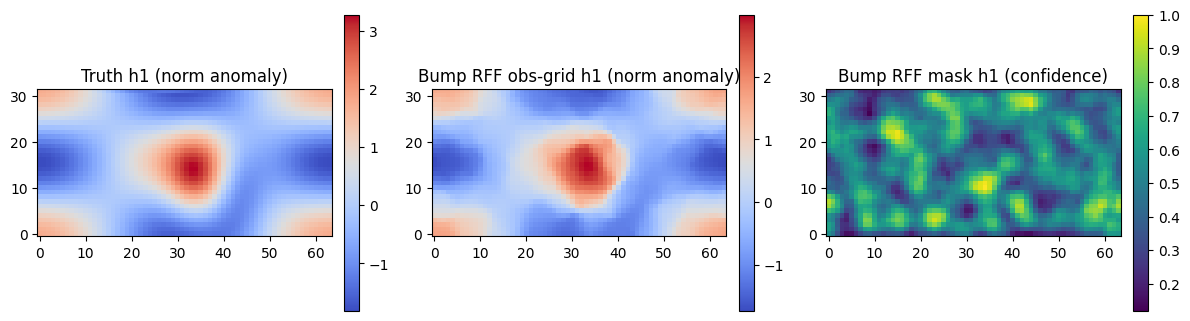

In [ ]:
# ============================================================
# Quick sanity check: h1 truth vs obs-grid vs mask
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# If C_state isn't defined yet in this notebook, uncomment:
# C_state = Y.shape[1]  # should be 6 for [h1,h2,u1,v1,u2,v2]

# Choose which sample to inspect
i_plot = 0

# h1 in normalized anomaly units
h1_truth = Y[i_plot, 0]           # (H,W)  truth (normalized anomaly)
h1_obs   = X[i_plot, 0]           # (H,W)  obs-mapped grid for h1
h1_mask  = X[i_plot, C_state]     # (H,W)  mask/confidence for h1

# Remove means to emphasize anomaly structure
h1_truth_anom = h1_truth - h1_truth.mean()
h1_obs_anom   = h1_obs   - h1_obs.mean()

# Label the mapping you’re using (purely cosmetic)
#mapping_label = "Gaussian RBF"    # or "Adjoint", or "Bump RBF"
#mapping_label = "Gaussian RBF"    # or "Adjoint", or "Bump RBF"
mapping_label = "Bump RFF"    # or "Adjoint", or "Bump RBF"

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

im0 = axs[0].imshow(h1_truth_anom, origin="lower", cmap="coolwarm")
axs[0].set_title("Truth h1 (norm anomaly)")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(h1_obs_anom, origin="lower", cmap="coolwarm")
axs[1].set_title(f"{mapping_label} obs-grid h1 (norm anomaly)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(h1_mask, origin="lower")
axs[2].set_title(f"{mapping_label} mask h1 (confidence)")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# **5. U-Net with periodic-x, wall-like y convs**

In [ ]:
class PeriodicXConv2d(nn.Module):
    """
    3x3 conv:
      - periodic in x
      - reflect in y (wall-like)
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pad = 1
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=0)
        self.bn   = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        p = self.pad
        # periodic x pad
        x = torch.cat([x[..., -p:], x, x[..., :p]], dim=3)
        # reflect y pad
        x = F.pad(x, (0, 0, p, p), mode="reflect")
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class DoubleConvPeriodicX(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = PeriodicXConv2d(in_ch, out_ch)
        self.conv2 = PeriodicXConv2d(out_ch, out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConvPeriodicX(in_ch, out_ch)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = DoubleConvPeriodicX(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1,
                   [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2],
                   mode="reflect")
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet2D_Klein(nn.Module):
    """
    U-Net for Klein-β DA:
      input:  (B, C_in, H, W)  [RBF obs, mask]
      output: (B, 6, H, W) normalized anomalies
    """
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc   = DoubleConvPeriodicX(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.up1   = Up(128 + 64, 64)
        self.up2   = Up(64 + 32, 32)
        self.outc  = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x  = self.up1(x3, x2)
        x  = self.up2(x,  x1)
        logits = self.outc(x)
        return logits


N, C_in, H, W = X.shape
C_state = Y.shape[1]
print("N, C_in, C_state, H, W =", N, C_in, C_state, H, W)

model_unet = UNet2D_Klein(n_channels=C_in, n_classes=C_state).to(device)
print(model_unet)


N, C_in, C_state, H, W = 200 12 6 32 64
UNet2D_Klein(
  (inc): DoubleConvPeriodicX(
    (conv1): PeriodicXConv2d(
      (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): PeriodicXConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): Down(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv): DoubleConvPeriodicX(
      (conv1): PeriodicXConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): PeriodicXConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# **6. Data loaders + interior /wind-aware loss**

In [ ]:
X_torch = torch.from_numpy(X)
Y_torch = torch.from_numpy(Y)

idx = np.arange(N)
np.random.shuffle(idx)
n_train = int(0.8 * N)
idx_train = idx[:n_train]
idx_val   = idx[n_train:]

train_ds = TensorDataset(X_torch[idx_train], Y_torch[idx_train])
val_ds   = TensorDataset(X_torch[idx_val],   Y_torch[idx_val])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

# Interior mask
BORDER_ROWS = 2
interior_mask_np = np.ones((1, 1, H, W), dtype=np.float32)
interior_mask_np[:, :, :BORDER_ROWS, :]  = 0.0
interior_mask_np[:, :, -BORDER_ROWS:, :] = 0.0
interior_mask = torch.from_numpy(interior_mask_np).to(device)

criterion = nn.MSELoss(reduction="none")

# weights for channels: [h1,h2,u1,v1,u2,v2]
w_channels = np.array([1.0, 1.0, 2.0, 2.0, 2.0, 2.0], dtype=np.float32)
w_channels_t = torch.from_numpy(w_channels.reshape(1, C_state, 1, 1)).to(device)

def loss_interior_weighted(pred, target):
    """
    interior-only, wind-weighted MSE
    """
    se = (pred - target) ** 2                      # (B,C,H,W)
    se = se * interior_mask * w_channels_t         # broadcast
    se_sum = se.sum()
    n_spatial = interior_mask.sum()
    B, C, _, _ = pred.shape
    n_total = n_spatial * B * C
    return se_sum / n_total


def eval_rmse_interior(model, loader, device):
    model.eval()
    se_sum = 0.0
    n_vals = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            se = (out - yb) ** 2 * interior_mask
            se_sum += se.sum().item()
            B, C, _, _ = out.shape
            n_vals += interior_mask.sum().item() * B * C
    mse = se_sum / n_vals
    return np.sqrt(mse)


Train samples: 160 Val samples: 40


# **7. Training**

Epoch 001 | train_loss=1.330e+00 | val_RMSE_int=9.724e-01
Epoch 002 | train_loss=8.546e-01 | val_RMSE_int=7.137e-01
Epoch 003 | train_loss=6.767e-01 | val_RMSE_int=5.912e-01
Epoch 004 | train_loss=5.522e-01 | val_RMSE_int=5.441e-01
Epoch 005 | train_loss=4.538e-01 | val_RMSE_int=4.833e-01
Epoch 006 | train_loss=3.815e-01 | val_RMSE_int=4.486e-01
Epoch 007 | train_loss=3.238e-01 | val_RMSE_int=4.179e-01
Epoch 008 | train_loss=2.805e-01 | val_RMSE_int=3.974e-01
Epoch 009 | train_loss=2.390e-01 | val_RMSE_int=3.653e-01
Epoch 010 | train_loss=2.157e-01 | val_RMSE_int=3.407e-01
Epoch 011 | train_loss=1.904e-01 | val_RMSE_int=3.219e-01
Epoch 012 | train_loss=1.687e-01 | val_RMSE_int=3.019e-01
Epoch 013 | train_loss=1.481e-01 | val_RMSE_int=2.879e-01
Epoch 014 | train_loss=1.389e-01 | val_RMSE_int=2.835e-01
Epoch 015 | train_loss=1.287e-01 | val_RMSE_int=2.595e-01
Epoch 016 | train_loss=1.169e-01 | val_RMSE_int=2.517e-01
Epoch 017 | train_loss=1.054e-01 | val_RMSE_int=2.376e-01
Epoch 018 | tr

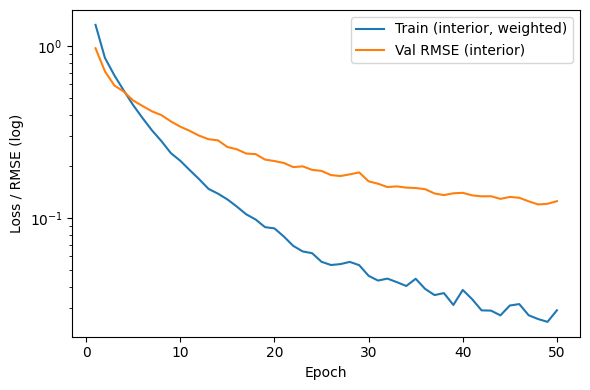

In [ ]:
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=1e-4)

n_epochs = 50
train_losses = []
val_rmses = []

for epoch in range(1, n_epochs + 1):
    model_unet.train()
    total_loss = 0.0
    n_samp = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model_unet(xb)
        loss = loss_interior_weighted(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n_samp += xb.size(0)

    train_loss = total_loss / n_samp
    val_rmse = eval_rmse_interior(model_unet, val_loader, device)

    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.3e} | val_RMSE_int={val_rmse:.3e}")

# Curves
epochs_arr = np.arange(1, n_epochs + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs_arr, train_losses, label="Train (interior, weighted)")
plt.plot(epochs_arr, val_rmses, label="Val RMSE (interior)")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE (log)")
plt.legend()
plt.tight_layout()
plt.show()


## 7a. RMSE per variable


RMSE per variable (normalized units, interior only):
h1: RMSE_norm =   0.1119
h2: RMSE_norm =   0.1123
u1: RMSE_norm =   0.1265
v1: RMSE_norm =   0.1306
u2: RMSE_norm =   0.1304
v2: RMSE_norm =   0.1396


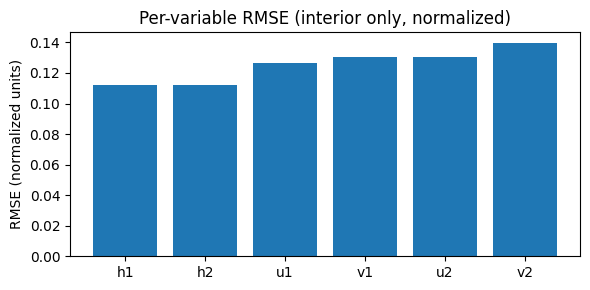

In [ ]:
# ============================================================
# 7.5  RMSE diagnostics per variable (normalized units)
#      (matching interior-only loss if interior_mask is used)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def eval_rmse_per_channel_norm(model, loader, device, interior_mask=None):
    """
    Compute RMSE per channel over the validation set in *normalized* units.

    model:        trained UNet
    loader:       val_loader
    device:       cuda/cpu
    interior_mask: (1,1,H,W) or None.
                   If not None, RMSE is computed only where mask==1.
    Returns:
        rmse: np.array of shape (C_state,)
    """
    model.eval()
    C = C_state
    se_sum = np.zeros(C, dtype=np.float64)
    n_vals = np.zeros(C, dtype=np.float64)

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)                 # (B,C,H,W)

            err = out - yb                  # (B,C,H,W)
            se = err ** 2                   # (B,C,H,W)

            if interior_mask is not None:
                se = se * interior_mask     # broadcast (1,1,H,W)
                n_spatial = interior_mask.sum().item()
            else:
                _, _, H_, W_ = se.shape
                n_spatial = H_ * W_

            B = xb.size(0)
            se_sum += se.sum(dim=(0, 2, 3)).cpu().numpy()
            n_vals += n_spatial * B

    mse = se_sum / n_vals
    rmse = np.sqrt(mse)
    return rmse


# --- Compute RMSE per variable (normalized units) ---
rmse_norm = eval_rmse_per_channel_norm(
    model_unet,
    val_loader,
    device,
    interior_mask=interior_mask  # or None if you want full domain
)

print("\nRMSE per variable (normalized units, interior only):")
for c, name in enumerate(var_names):
    print(f"{name:>2}: RMSE_norm = {rmse_norm[c]:8.4f}")


# --- Optional: bar plot of normalized RMSE ---
plt.figure(figsize=(6, 3))
plt.bar(np.arange(C_state), rmse_norm)
plt.xticks(np.arange(C_state), var_names)
plt.ylabel("RMSE (normalized units)")
plt.title("Per-variable RMSE (interior only, normalized)")
plt.tight_layout()
plt.show()


# **8. Plot anomalies: Truth vs recon (normalized)**


Global RMSE per variable (normalized, interior-only, all validation samples):
h1: RMSE_norm_global =   0.1119
h2: RMSE_norm_global =   0.1123
u1: RMSE_norm_global =   0.1265
v1: RMSE_norm_global =   0.1306
u2: RMSE_norm_global =   0.1304
v2: RMSE_norm_global =   0.1396

Sample RMSE per variable (normalized, interior-only) for idx_example = 0
h1: RMSE_norm_sample =   0.0765
h2: RMSE_norm_sample =   0.0821
u1: RMSE_norm_sample =   0.0874
v1: RMSE_norm_sample =   0.0747
u2: RMSE_norm_sample =   0.0924
v2: RMSE_norm_sample =   0.0867

Sample RMSE (all vars, interior-only, normalized): 0.0835



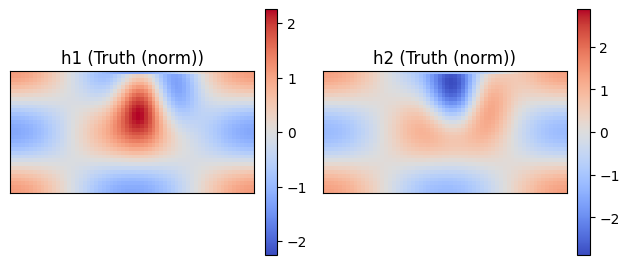

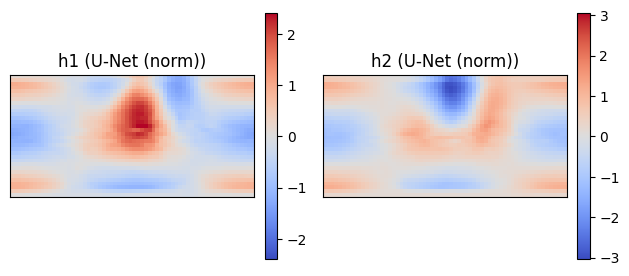

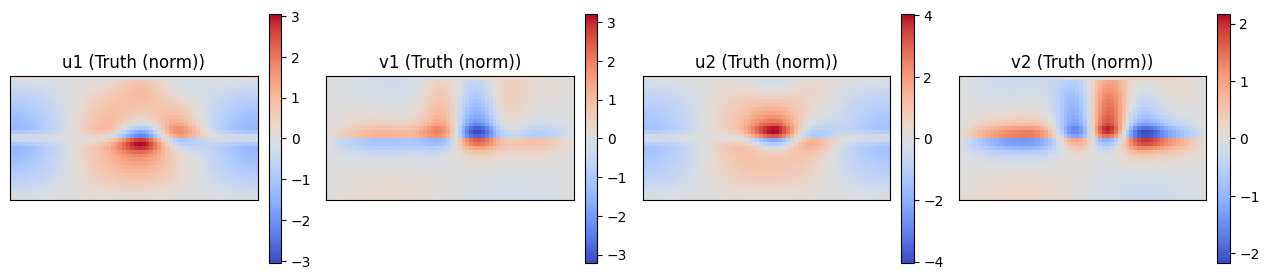

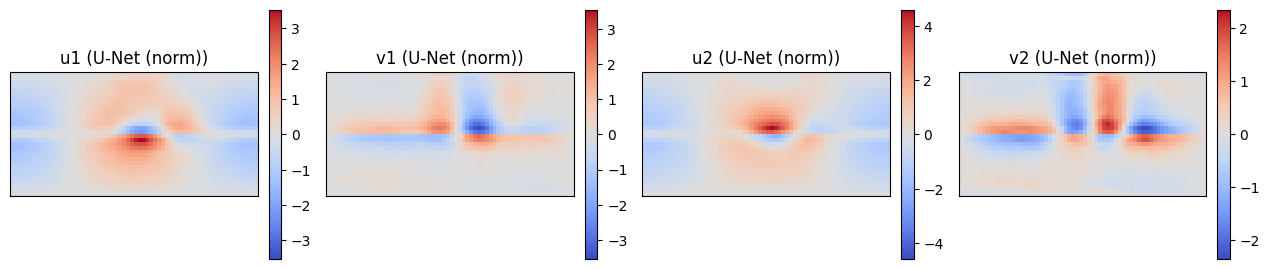

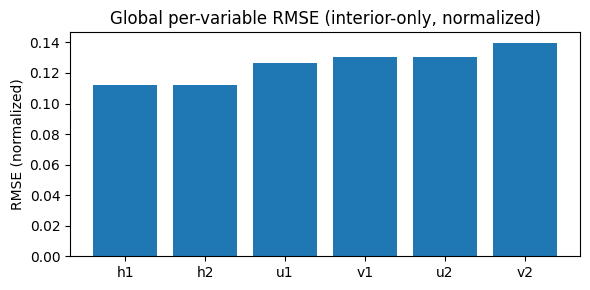

In [ ]:
# ============================================================
# 8. Plot anomalies: Truth vs Recon (normalized) + RMSE prints
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def plot_anomalies_select_vars(data, idx=0, var_names=None, var_indices=None, title_prefix=""):
    """
    Visualize anomalies for selected variables in one sample.
    """
    sample = data[idx]  # (C,H,W)
    C, H, W = sample.shape

    if var_names is None:
        var_names = [f"var{c}" for c in range(C)]
    if var_indices is None:
        var_indices = list(range(C))

    n_plot = len(var_indices)
    fig, axs = plt.subplots(1, n_plot, figsize=(3.2*n_plot, 3))
    if n_plot == 1:
        axs = [axs]

    for j, c in enumerate(var_indices):
        fld = sample[c]
        anom = fld - fld.mean()
        vmax = np.max(np.abs(anom))
        if vmax == 0:
            vmax = 1e-6
        im = axs[j].imshow(anom, origin="lower", cmap="coolwarm",
                           vmin=-vmax, vmax=vmax)
        axs[j].set_title(f"{var_names[c]} ({title_prefix})")
        axs[j].set_xticks([]); axs[j].set_yticks([])
        plt.colorbar(im, ax=axs[j], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


# --- 1. Run model on one validation batch ---
model_unet.eval()
with torch.no_grad():
    xb_batch, yb_batch = next(iter(val_loader))
    xb_batch = xb_batch.to(device)
    yb_batch = yb_batch.to(device)
    y_pred_batch = model_unet(xb_batch)

y_true = yb_batch.cpu().numpy()   # (B,C,H,W)
y_pred = y_pred_batch.cpu().numpy()


# --- 2. Choose which validation sample to inspect ---
idx_example = 0  # change this to look at other examples


# --- 3. Compute sample RMSEs (normalized, interior-only) ---
mask_np = interior_mask.cpu().numpy()[0, 0]    # (H,W), 1 in interior, 0 at borders

err = y_true[idx_example] - y_pred[idx_example]   # (C,H,W)
se  = err**2                                      # (C,H,W)

# interior-only
se_masked = se * mask_np[None, :, :]              # (C,H,W)

# per-variable sample RMSE (normalized, interior-only)
num_points_int = mask_np.sum()                    # interior points per variable
sample_rmse_int_by_var = np.sqrt(
    se_masked.reshape(C_state, -1).sum(axis=1) / num_points_int
)  # (C,)

# overall sample RMSE across all vars (normalized, interior-only)
num_points_total = num_points_int * C_state
sample_rmse_int_all = np.sqrt(se_masked.sum() / num_points_total)


# --- 4. Print RMSE values ---

# Global RMSE per variable from step 7.5 (rmse_norm)
print("\nGlobal RMSE per variable (normalized, interior-only, all validation samples):")
for c, name in enumerate(var_names):
    print(f"{name:>2}: RMSE_norm_global = {rmse_norm[c]:8.4f}")

print("\nSample RMSE per variable (normalized, interior-only) for idx_example =", idx_example)
for c, name in enumerate(var_names):
    print(f"{name:>2}: RMSE_norm_sample = {sample_rmse_int_by_var[c]:8.4f}")

print(f"\nSample RMSE (all vars, interior-only, normalized): {sample_rmse_int_all:.4f}\n")


# --- 5. Plot selected variables for that sample ---

wind_vars   = [2, 3, 4, 5]  # u1, v1, u2, v2
height_vars = [0, 1]        # h1, h2

# Heights
plot_anomalies_select_vars(y_true, idx_example,
                           var_names=var_names,
                           var_indices=height_vars,
                           title_prefix="Truth (norm)")
plot_anomalies_select_vars(y_pred, idx_example,
                           var_names=var_names,
                           var_indices=height_vars,
                           title_prefix="U-Net (norm)")

# Winds
plot_anomalies_select_vars(y_true, idx_example,
                           var_names=var_names,
                           var_indices=wind_vars,
                           title_prefix="Truth (norm)")
plot_anomalies_select_vars(y_pred, idx_example,
                           var_names=var_names,
                           var_indices=wind_vars,
                           title_prefix="U-Net (norm)")


# --- 6. Optional: bar plot of global RMSE per variable ---

plt.figure(figsize=(6, 3))
plt.bar(np.arange(C_state), rmse_norm)
plt.xticks(np.arange(C_state), var_names)
plt.ylabel("RMSE (normalized)")
plt.title("Global per-variable RMSE (interior-only, normalized)")
plt.tight_layout()
plt.show()
